<a href="https://colab.research.google.com/github/VadimFarutin/deep-unsupervised-learning/blob/hw03/hw03_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW03

## 1 VAEs in 2D

### Imports and common code

In [0]:
%%capture
!pip install graphql-core==2.0
!pip install wandb -q

In [0]:
import wandb
!wandb login

In [0]:
from collections import defaultdict
from tqdm import tnrange, tqdm_notebook
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import random
import pickle

import torch
import torch.nn as nn
import torch.nn.utils as utils
from torch.nn.modules import loss
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.distributions import Normal, Uniform, MultivariateNormal

In [0]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [0]:
EPS = 1e-9

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')
print(DEVICE)

cuda


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def MyVAELosses(x, mu_x, var_x, mu_z, var_z):
    nll = -torch.sum(-0.5 * (torch.log(2 * np.pi * var_x) + torch.pow(x - mu_x, 2) / var_x), dim=1, keepdim=True)
    kl_div = -0.5 * torch.sum(1.0 + torch.log(var_z) - torch.pow(mu_z, 2) - var_z, dim=1, keepdim=True)

    return torch.mean(kl_div + nll), torch.mean(kl_div), torch.mean(nll) / 2.0

In [0]:
def fit(model, train, val, test, optimizer1, optimizer2, loss_function, epoch_cnt, batch_size):
    train_loader = torch.utils.data.DataLoader(torch.from_numpy(train), batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(torch.from_numpy(val), batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(torch.from_numpy(test), batch_size=batch_size)
    train_loss_values = []
    val_loss_values = []
            
    for epoch in tnrange(epoch_cnt, desc='Epoch'):
        model.train()
        for batch_data in train_loader:
            x = batch_data.float().to(DEVICE)
            optimizer1.zero_grad()
            optimizer2.zero_grad()
            mu_x, var_x, mu_z, var_z = model(x)
            loss, kl_div, nll = loss_function(x, mu_x, var_x, mu_z, var_z)
            loss.backward()
            optimizer1.step()
            optimizer2.step()
            train_loss_values.append([loss.item(), kl_div.item(), nll.item()])

        loss_values = []
        model.eval()
        for batch_data in val_loader:
            x = batch_data.float().to(DEVICE)
            mu_x, var_x, mu_z, var_z = model(x)
            loss, kl_div, nll = loss_function(x, mu_x, var_x, mu_z, var_z)
            loss_values.append([loss.item(), kl_div.item(), nll.item()])
        val_loss_values.append(np.mean(np.array(loss_values), axis=0))
    
    loss_values = []
    model.eval()
    for batch_data in test_loader:
        x = batch_data.float().to(DEVICE)
        mu_x, var_x, mu_z, var_z = model(x)
        loss, kl_div, nll = loss_function(x, mu_x, var_x, mu_z, var_z)
        loss_values.append([loss.item(), kl_div.item(), nll.item()])

    print("Test set loss: ", np.mean(np.array(loss_values), axis=0))

    return np.array(train_loss_values), np.array(val_loss_values) 


In [0]:
def plot_loss_values(train_loss_values, val_loss_values, ax, title):
    ax.plot(np.arange(len(train_loss_values)), train_loss_values, color='blue', label='train')
    ax.plot(np.arange(0, len(train_loss_values), len(train_loss_values) / epochs), val_loss_values, color='red', label='validation')
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel("iteration")
    ax.set_ylabel(title)

def plot_samples(decoder, n, ax):
    z = torch.randn([n, 2]).to(DEVICE)
    mu_x, var_x = decoder(z)
    x = mu_x + torch.randn([n, 2]).to(DEVICE) * torch.sqrt(var_x)

    x = x.cpu().data.numpy()
    mu_x = mu_x.cpu().data.numpy()
    
    ax.scatter(x[:, 0], x[:, 1], marker='.', label='Full generation path')
    ax.scatter(mu_x[:, 0], mu_x[:, 1], marker='.', label='Without decoder noise')

def plot_losses_and_samples(train_loss_values, val_loss_values, decoder, n):
    fig = plt.figure(figsize=(7, 7))
    gs = gridspec.GridSpec(2, 2)

    plot_loss_values(train_loss_values[:, 0], val_loss_values[:, 0], plt.subplot(gs[0]), "Loss")
    plot_loss_values(train_loss_values[:, 1], val_loss_values[:, 1], plt.subplot(gs[1]), "KL")
    plot_loss_values(train_loss_values[:, 2], val_loss_values[:, 2], plt.subplot(gs[2]), "Decoder")
    plot_samples(decoder, n, plt.subplot(gs[3]))


## 1.1 Part A

In [0]:
def sample_data_1():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]

def sample_data_2():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot([[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])


In [206]:
X1 = sample_data_1()
X2 = sample_data_2()
X1_train, X1_test = train_test_split(X1, test_size=0.2)
X1_train, X1_val = train_test_split(X1_train, test_size=0.125)
X2_train, X2_test = train_test_split(X2, test_size=0.2)
X2_train, X2_val = train_test_split(X2_train, test_size=0.125)

print(X1_train.shape, X1_val.shape, X1_test.shape)


(70000, 2) (10000, 2) (20000, 2)


In [0]:
class Encoder(nn.Module):
    def __init__(self, hidden_size=128):
        super(Encoder, self).__init__()

        self.layers = nn.Sequential(nn.Linear(2, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, 4))
            
    def forward(self, x):
        out = self.layers(x)
        mu, log_var = torch.split(out, 2, dim=1)

        return mu, torch.exp(log_var)

    def __call__(self, x):
        return self.forward(x)

In [0]:
class Decoder1(nn.Module):
    def __init__(self, hidden_size=128):
        super(Decoder1, self).__init__()

        self.layers = nn.Sequential(nn.Linear(2, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, 4))
            
    def forward(self, x):
        out = self.layers(x)
        mu, log_var = torch.split(out, 2, dim=1)

        return mu, torch.exp(log_var)

    def __call__(self, x):
        return self.forward(x)

In [0]:
class Decoder2(nn.Module):
    def __init__(self, hidden_size=128):
        super(Decoder2, self).__init__()
       
        self.layers = nn.Sequential(nn.Linear(2, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, 3))
            
    def forward(self, x):
        out = self.layers(x)
        mu, log_var = torch.split(out, 2, dim=1)
        var = torch.exp(log_var * torch.ones([1, 2]).to(DEVICE))

        return mu, var

    def __call__(self, x):
        return self.forward(x)

In [0]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
       
        self.encoder = encoder
        self.decoder = decoder
            
    def forward(self, x):
        mu_z, var_z = encoder(x)
        z = mu_z + torch.randn(x.shape).to(DEVICE) * torch.sqrt(var_z)
        mu_x, var_x = decoder(z)

        return mu_x, var_x, mu_z, var_z


    def __call__(self, x):
        return self.forward(x)

In [0]:
hidden_size = 128
lr = 1e-3
batch_size = 128
epochs = 10
n_samples = 10000

In [172]:
encoder, decoder = Encoder(hidden_size=hidden_size), Decoder1(hidden_size=hidden_size)
model = VAE(encoder, decoder).float().to(DEVICE)
loss_function = MyVAELosses
optimizer1, optimizer2 = optim.Adam(encoder.parameters(), lr=lr), optim.Adam(decoder.parameters(), lr=lr)

train_loss_values, val_loss_values =\
    fit(model, X1_train, X1_val, X1_test, optimizer1, optimizer2, loss_function, epochs, batch_size)


Test set loss:  [4.44404249e+00 1.54236319e-03 2.22125006e+00]


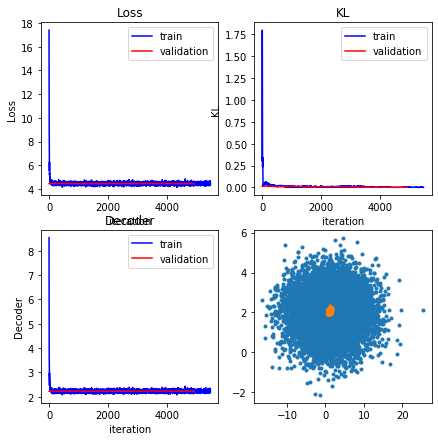

In [173]:
plot_losses_and_samples(train_loss_values, val_loss_values, decoder, n_samples)

In [197]:
encoder, decoder = Encoder(hidden_size=hidden_size), Decoder1(hidden_size=hidden_size)
model = VAE(encoder, decoder).float().to(DEVICE)
loss_function = MyVAELosses
optimizer1, optimizer2 = optim.Adam(encoder.parameters(), lr=lr), optim.Adam(decoder.parameters(), lr=lr)

train_loss_values, val_loss_values =\
    fit(model, X2_train, X2_val, X2_test, optimizer1, optimizer2, loss_function, epochs, batch_size)


Test set loss:  [4.4802326  1.55499981 1.46261639]


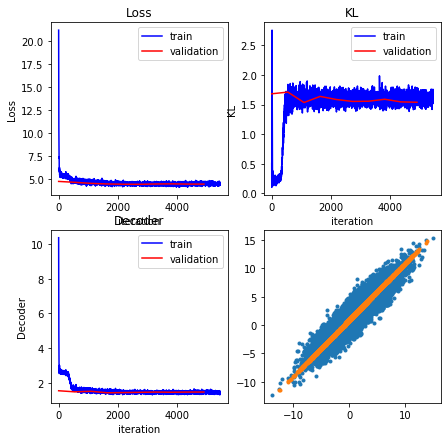

In [198]:
plot_losses_and_samples(train_loss_values, val_loss_values, decoder, n_samples)

In [203]:
encoder, decoder = Encoder(hidden_size=hidden_size), Decoder2(hidden_size=hidden_size)
model = VAE(encoder, decoder).float().to(DEVICE)
loss_function = MyVAELosses
optimizer1, optimizer2 = optim.Adam(encoder.parameters(), lr=lr), optim.Adam(decoder.parameters(), lr=lr)

train_loss_values, val_loss_values =\
    fit(model, X1_train, X1_val, X1_test, optimizer1, optimizer2, loss_function, epochs, batch_size)


Test set loss:  [4.4647827  1.6255816  1.41960054]


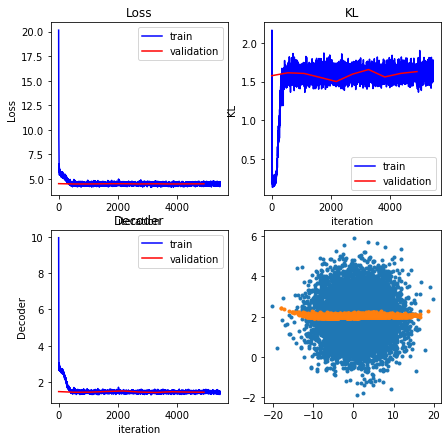

In [204]:
plot_losses_and_samples(train_loss_values, val_loss_values, decoder, n_samples)

In [184]:
encoder, decoder = Encoder(hidden_size=hidden_size), Decoder2(hidden_size=hidden_size)
model = VAE(encoder, decoder).float().to(DEVICE)
loss_function = MyVAELosses
optimizer1, optimizer2 = optim.Adam(encoder.parameters(), lr=lr), optim.Adam(decoder.parameters(), lr=lr)

train_loss_values, val_loss_values =\
    fit(model, X2_train, X2_val, X2_test, optimizer1, optimizer2, loss_function, epochs, batch_size)


Test set loss:  [4.45877213 1.60807356 1.42534926]


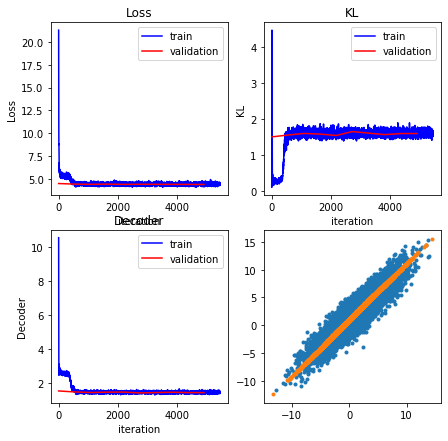

In [185]:
plot_losses_and_samples(train_loss_values, val_loss_values, decoder, n_samples)

## 1.2 Part B

In [0]:
def sample_data_3():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)), -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

In [208]:
X, y = sample_data_3()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125)

print(X_train.shape, X_val.shape, X_test.shape)

(69999, 2) (10000, 2) (20000, 2)


In [0]:
hidden_size = 128
lr = 1e-3
batch_size = 10000
epochs = 1000
n_samples = 1000

In [0]:
encoder, decoder = Encoder(hidden_size=hidden_size), Decoder1(hidden_size=hidden_size)
model = VAE(encoder, decoder).float().to(DEVICE)
loss_function = MyVAELosses
optimizer1, optimizer2 = optim.Adam(encoder.parameters(), lr=lr), optim.Adam(decoder.parameters(), lr=lr)

In [232]:
train_loss_values, val_loss_values =\
    fit(model, X_train, X_val, X_test, optimizer1, optimizer2, loss_function, epochs, batch_size)

Test set loss:  [ 1.41784912  4.46038556 -1.52126801]


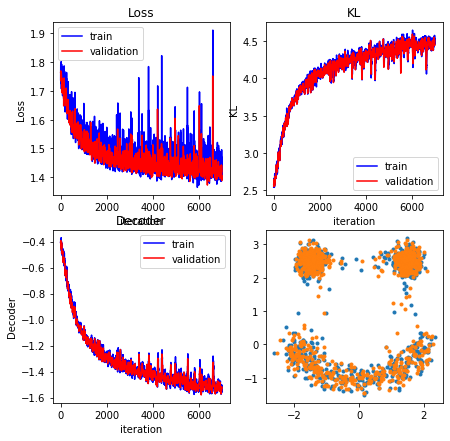

In [233]:
plot_losses_and_samples(train_loss_values, val_loss_values, decoder, n_samples)

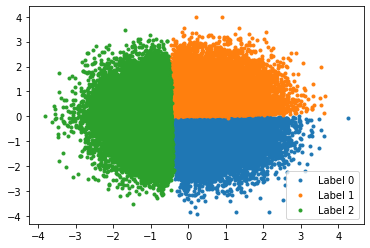

In [234]:
mu_z, var_z = encoder(torch.from_numpy(X_train).float().to(DEVICE))
z = mu_z + torch.randn(X_train.shape).float().to(DEVICE) * torch.sqrt(var_z)
z = z.cpu().data.numpy()
plt.scatter(z[y_train == 0, 0], z[y_train == 0, 1], marker='.', label='Label 0')
plt.scatter(z[y_train == 1, 0], z[y_train == 1, 1], marker='.', label='Label 1')
plt.scatter(z[y_train == 2, 0], z[y_train == 2, 1], marker='.', label='Label 2')
plt.legend()

In [0]:
def prob(x, mu, var):
    prob =  torch.exp(-0.5 * torch.pow(x - mu, 2) / var) / torch.sqrt(2.0 * np.pi * var)
    return prob[:, :, 0:1] * prob[:, :, 1:]


def IWAE(x, n_samples):
    mu_z, var_z = encoder(x)
    mu_z = torch.unsqueeze(mu_z, dim=0)
    var_z = torch.unsqueeze(var_z, dim=0)
    z = mu_z + torch.randn([n_samples, x.shape[0], x.shape[1]]).to(DEVICE) * torch.sqrt(var_z)

    mu_x, var_x = decoder(z.view([-1, 2]))
    mu_x = mu_x.view(z.shape)
    var_x = var_x.view(z.shape)

    p_x_z = prob(x, mu_x, var_x)
    p_z = prob(z, torch.zeros_like(mu_z).to(DEVICE), torch.ones_like(var_z).to(DEVICE))
    q_z_x = prob(z, mu_z, var_z)

    iwae = torch.mean(p_x_z * p_z / q_z_x, dim=0)
    iwae = torch.mean(torch.log(iwae))

    return iwae

In [236]:
x = torch.from_numpy(X_test[:100]).float().cuda()
elbo = IWAE(x, n_samples=1)
iwae = IWAE(x, n_samples=100)

print("ELBO: {:.6f}".format(elbo.item()))
print("IWAE: {:.6f}".format(iwae.item()))

ELBO: -1.489221
IWAE: -1.421867
